In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

demand_data = pd.read_csv('data\dataset\demand.csv')
vehicle_data = pd.read_csv('vehicle_data_edit.csv')
vehicle_fuels = pd.read_csv('data/dataset/vehicles_fuels.csv')
fuels_data = pd.read_csv('data/dataset/fuels.csv')
carbon_emissions_data = pd.read_csv('data/dataset/carbon_emissions.csv')
cost_profiles = pd.read_csv('data/dataset/cost_profiles.csv')

def feasible_vehicle(yr, s,d):
    temp_df = vehicle_data.loc[(vehicle_data['Year'] <= yr) & (vehicle_data['Size'] == s)]
    if d == 'D2':
        temp_df = temp_df.loc[temp_df['Distance'] != 'D1']
    elif d == 'D3':
        temp_df = temp_df.loc[(temp_df['Distance'] == 'D3') | (temp_df['Distance'] == 'D4')]
    elif d == 'D4':
        temp_df = temp_df.loc[(temp_df['Distance'] == 'D4')]
    return temp_df

def feasible_vehicle_buy(yr, s,d):
    temp_df = vehicle_data.loc[(vehicle_data['Year'] == yr) & (vehicle_data['Size'] == s)]
    if d == 'D2':
        temp_df = temp_df.loc[temp_df['Distance'] != 'D1']
    elif d == 'D3':
        temp_df = temp_df.loc[(temp_df['Distance'] == 'D3') | (temp_df['Distance'] == 'D4')]
    elif d == 'D4':
        temp_df = temp_df.loc[(temp_df['Distance'] == 'D4')]
    return temp_df

def decide_vehicle(feas_veh, prob):
    rand = random.random()
    for i in range(len(prob)):
        if rand < sum(prob[:i+1]):
            return feas_veh.iloc[i]
        
def feasible_from_avail_vehicle(avail_vehicle, feas_veh):
    new_feas_vehicle = []
    arr_distance = []
    for k in range(len(avail_vehicle['ID'])):
        i = avail_vehicle['ID'][k]
        if i in feas_veh['ID'].tolist():
            new_feas_vehicle.append(i)
            arr_distance.append(avail_vehicle['distance'][k])
    return {'ID': new_feas_vehicle, 'distance': arr_distance}

def sort_vehicle(vehicle_dict):
    list_BEV = []
    list_BEV_dist = []
    list_LNG = []
    list_LNG_dist = []
    list_diesel = []
    list_diesel_dist = []
    n = len(vehicle_dict['ID'])
    for k in range(n):
        i = vehicle_dict['ID'][0]
        temp = i.split('_')
        if temp[0] == 'BEV':
            list_BEV.append(i)
            list_BEV_dist.append(vehicle_dict['distance'][0])
        elif temp[0] == 'LNG':
            list_LNG.append(i)
            list_LNG_dist.append(vehicle_dict['distance'][0])
        else:
            list_diesel.append(i)
            list_diesel_dist.append(vehicle_dict['distance'][0])
        del vehicle_dict['ID'][0]
        del vehicle_dict['distance'][0]

    return {'ID': list_BEV + list_LNG + list_diesel, 'distance': list_BEV_dist + list_LNG_dist + list_diesel_dist}

def count_year_vehicle(list_vehicle):
    dict_year = {}
    for i in range(2023,2039):
        dict_year[i] = 0
        for j in range(len(list_vehicle)):
            veh = list_vehicle[j]
            year_buy = veh.split('_')
            year_buy = year_buy[-1]
            if year_buy == str(i):
                dict_year[i] += 1
    return dict_year

def func_cost_fuel(veh_type, vehicle_fuel, yearly_dist, year):
    if veh_type == 'LNG':
        #cost fuel non eco
        consumption_unit = vehicle_fuel.loc[(vehicle_fuel['Fuel'] == 'LNG')]
        consumption_unit = consumption_unit['Consumption (unit_fuel/km)'].iloc[0]
        cost_per_fuel = fuels_data.loc[(fuels_data['Fuel'] == 'LNG') & (fuels_data['Year'] == year)]
        cost_per_fuel = cost_per_fuel['Cost ($/unit_fuel)'].iloc[0]
        dist = (1-env_friendly_benchmark[year-2023])*yearly_dist
        cost_non_eco = consumption_unit*cost_per_fuel*dist

        #cost eco
        consumption_unit = vehicle_fuel.loc[(vehicle_fuel['Fuel'] == 'BioLNG')]
        consumption_unit = consumption_unit['Consumption (unit_fuel/km)'].iloc[0]
        cost_per_fuel = fuels_data.loc[(fuels_data['Fuel'] == 'BioLNG') & (fuels_data['Year'] == year)]
        cost_per_fuel = cost_per_fuel['Cost ($/unit_fuel)'].iloc[0]
        dist = (env_friendly_benchmark[year-2023])*yearly_dist
        cost_eco = consumption_unit*cost_per_fuel*dist
        # cost_fuel = cost_eco + cost_non_eco
    elif veh_type == 'Diesel':
        #cost fuel non eco
        consumption_unit = vehicle_fuel.loc[(vehicle_fuel['Fuel'] == 'B20')]
        consumption_unit = consumption_unit['Consumption (unit_fuel/km)'].iloc[0]
        cost_per_fuel = fuels_data.loc[(fuels_data['Fuel'] == 'B20') & (fuels_data['Year'] == year)]
        cost_per_fuel = cost_per_fuel['Cost ($/unit_fuel)'].iloc[0]
        dist = (1-env_friendly_benchmark[year-2023])*yearly_dist
        cost_non_eco = consumption_unit*cost_per_fuel*dist

        #cost eco
        consumption_unit = vehicle_fuel.loc[(vehicle_fuel['Fuel'] == 'HVO')]
        consumption_unit = consumption_unit['Consumption (unit_fuel/km)'].iloc[0]
        cost_per_fuel = fuels_data.loc[(fuels_data['Fuel'] == 'HVO') & (fuels_data['Year'] == year)]
        cost_per_fuel = cost_per_fuel['Cost ($/unit_fuel)'].iloc[0]
        dist = (env_friendly_benchmark[year-2023])*yearly_dist
        cost_eco = consumption_unit*cost_per_fuel*dist
        # cost_fuel = cost_eco + cost_non_eco
    else:
        cost_non_eco = 0
        consumption_unit = vehicle_fuel.loc[(vehicle_fuel['Fuel'] == 'Electricity')]
        consumption_unit = consumption_unit['Consumption (unit_fuel/km)'].iloc[0]
        cost_per_fuel = fuels_data.loc[(fuels_data['Fuel'] == 'Electricity') & (fuels_data['Year'] == year)]
        cost_per_fuel = cost_per_fuel['Cost ($/unit_fuel)'].iloc[0]
        dist = yearly_dist
        cost_eco = consumption_unit*cost_per_fuel*dist
        # cost_fuel = cost_eco + cost_non_eco
    return cost_eco + cost_non_eco
    
# def carbon_capture():

avail_vehicle = {'ID': [],
                 'buy_cost': [],
                 'distance': []}
total_fleet = {'ID': [],
               'buy_cost': [],
               'size': [],
               'distance_ability': [],
               'yearly_distance': []}

buy = {}
use = {}
sell = {}

unique_year = np.unique(demand_data['Year'])
s = np.unique(demand_data['Size'])
d = np.unique(demand_data['Distance'])

arr_cc = []
arr_cost_buy= []
arr_cost_ins = []
arr_cost_mnt = []
arr_cost_fuel = []
arr_total_cost = []
arr_cost_sell = []
arr_max_sold = []
arr_sold = []
env_friendly_benchmark = (np.array([0.1, 0.1, 0.1, 0.1, 0.2, 0.3, 0.5, 0.6, 0.6, 0.6, 0.6, 0.4, 0.1, 0.1, 0.1, 0.1]) - 0.1).tolist()

arr_cc_expected = carbon_emissions_data['Carbon emission CO2/kg'].tolist()

In [4]:
dict_year = {}
dict_year_sell = {}
dict_year_buy = {}
dict_total_fleet = {}
for yr in unique_year:
   dict_year[yr] = []
   dict_year_sell[yr] = []
   dict_year_buy[yr] = []
   dict_total_fleet[yr] = {'ID': []}

arr_env_friendly = []
coef_buy = 0.15518518
coef_sell = 0.19
for yr in unique_year:
   #buy
   buy[yr] = {'ID': [],
             'cost': [],
             'distance': []}
   use[yr] = {'ID': [],
             'size': [],
             'distance_bucket': [],
             'distance': []
             }
   print(yr)
   for i in range(len(s)):
      demand_avail = 0
      for j in range(len(d)-1,-1,-1):
         feas_veh = feasible_vehicle(yr,s[i],d[j])
         new_feas_vehicle = feasible_from_avail_vehicle(avail_vehicle,feas_veh)
         sorted_feas_vehicle = sort_vehicle(new_feas_vehicle)
         demand = demand_data['Demand (km)'].loc[(demand_data['Size'] == s[i]) & (demand_data['Distance'] == d[j]) & (demand_data['Year'] == yr)].iloc[0]
         while demand > 0:
            if (len(sorted_feas_vehicle['ID']) == 0) & (demand > 0):
               feas_veh = feasible_vehicle_buy(yr,s[i],d[j])
               yearly_cost = coef_buy*feas_veh['Cost ($)'] + feas_veh['fuel_cost']
               #0.265 = (cost + (total biaya ins+mnt selama 10 th) 1.95*cost - 0.3*cost (resale))/10 assume 1 kendaraan untuk 10 th
               #0.19 = (cost + 0.27*cost (ins+mnt 3 tahun) - 0.7*cost)/3 assume 1 kendaraan untuk 3 tahun
               feas_veh['yearly_cost'] = yearly_cost
               inv = 1/feas_veh['yearly_cost']
               inv[inv.idxmax()] = inv[inv.idxmax()]+1
               # inv[inv.idxmax()] = inv[inv.idxmax()]*6
               prob = (inv/sum(inv)).values
               temp_df_decide = decide_vehicle(feas_veh, prob)
               buy[yr]['ID'].append(temp_df_decide['ID'])
               buy[yr]['distance'].append(temp_df_decide['Yearly range (km)'])
               buy[yr]['cost'].append(temp_df_decide['Cost ($)'])
               sorted_feas_vehicle['ID'].append(temp_df_decide['ID'])
               sorted_feas_vehicle['distance'].append(temp_df_decide['Yearly range (km)'])
               avail_vehicle['ID'].append(temp_df_decide['ID'])
               avail_vehicle['buy_cost'].append(temp_df_decide['Cost ($)'])
               avail_vehicle['distance'].append(temp_df_decide['Yearly range (km)'])
            idx_used = np.argmin(np.abs(np.array(sorted_feas_vehicle['distance']) - demand))
            demand0 = demand
            demand = demand - sorted_feas_vehicle['distance'][idx_used]
            use[yr]['ID'].append(sorted_feas_vehicle['ID'][idx_used])
            use[yr]['size'].append(s[i])
            use[yr]['distance_bucket'].append(d[j])
            if demand < 0:
               use[yr]['distance'].append(demand0)
            else:
               use[yr]['distance'].append(sorted_feas_vehicle['distance'][idx_used])

            veh = sorted_feas_vehicle['ID'][idx_used]
            idx = avail_vehicle['ID'].index(veh)
            del avail_vehicle['ID'][idx]
            del avail_vehicle['distance'][idx]
            del avail_vehicle['buy_cost'][idx]

            del sorted_feas_vehicle['ID'][idx_used]
            del sorted_feas_vehicle['distance'][idx_used]
            
   #after buy
   total_fleet['ID'] = total_fleet['ID'] + buy[yr]['ID']
   total_fleet['buy_cost'] = total_fleet['buy_cost'] + buy[yr]['cost']
   arr_size = []
   arr_distance_ability = []
   arr_yearly_distance = []
   for i in range(len(buy[yr]['ID'])):
      veh = buy[yr]['ID'][i]
      temp_df = vehicle_data.loc[vehicle_data['ID'] == veh]
      arr_size.append(temp_df['Size'].iloc[0])
      arr_distance_ability.append(temp_df['Distance'].iloc[0])
      arr_yearly_distance.append(temp_df['Yearly range (km)'].iloc[0])
   total_fleet['size'] = total_fleet['size'] + arr_size
   total_fleet['distance_ability'] = total_fleet['distance_ability'] + arr_distance_ability
   total_fleet['yearly_distance'] = total_fleet['yearly_distance'] + arr_yearly_distance
   
   #after use
   df_use = pd.DataFrame(use[yr])
   #hitung carbon capture
   cc_real = np.inf
   prob_env_friendly = 0.0
   while cc_real > arr_cc_expected[yr-2023]:
      cc = 0
      use[yr]['fuel'] = []
      for i in range(len(df_use)):
         rand_num = random.random()
         veh = df_use['ID'].iloc[i]
         dist = df_use['distance'].iloc[i]
         temp_df = vehicle_fuels.loc[vehicle_fuels['ID'] == veh]
         veh_type = veh.split('_')
         veh_type = veh_type[0]
         if veh_type == 'BEV':
            fuel = 'Electricity'
         elif veh_type == 'LNG':
            if rand_num > prob_env_friendly:
               fuel = 'LNG'
            else:
               fuel = 'BioLNG'
         else:
            if rand_num > prob_env_friendly:
               fuel = 'B20'
            else:
               fuel = 'HVO'
         use[yr]['fuel'].append(fuel)
         consumption_unit = temp_df.loc[(temp_df['Fuel'] == fuel)]
         consumption_unit = consumption_unit['Consumption (unit_fuel/km)'].iloc[0]
         emission = fuels_data.loc[(fuels_data['Fuel'] == fuel) & (fuels_data['Year'] == yr)]
         emission = emission['Emissions (CO2/unit_fuel)'].iloc[0]
         cc_veh = consumption_unit*emission*dist
         cc = cc + cc_veh
      cc_real = cc
      prob_env_friendly += 0.1
      if (prob_env_friendly > 1) & (cc_real > arr_cc_expected[yr-2023]):
         print('exceed carbon tolerance, need revised available vehicle')
         break
   arr_cc.append(cc)
   arr_env_friendly.append(prob_env_friendly)

   #hitung cost
   #buy
   cost_buy = 0
   for i in buy[yr]['ID']:
      veh_cost = vehicle_data.loc[(vehicle_data['ID'] == i)]
      veh_cost = veh_cost['Cost ($)'].iloc[0]
      cost_buy = cost_buy + veh_cost

   #avail
   cost_ins = 0
   cost_mnt = 0
   for i in range(len(total_fleet['ID'])):
      veh = total_fleet['ID'][i]
      year_buy = veh.split('_')
      year_buy = int(year_buy[-1])
      delta_year = yr - year_buy + 1
      temp_df = cost_profiles.loc[cost_profiles['End of Year'] == delta_year]
      pct_ins = temp_df['Insurance Cost %'].iloc[0]/100
      pct_mnt = temp_df['Maintenance Cost %'].iloc[0]/100
      cost_ins = cost_ins + pct_ins*total_fleet['buy_cost'][i]
      cost_mnt = cost_mnt + pct_mnt*total_fleet['buy_cost'][i]

   #cost fuel
   total_cost_fuel = 0
   for i in range(len(use[yr]['ID'])):
      veh = use[yr]['ID'][i]
      dist = use[yr]['distance'][i]
      temp_df = vehicle_fuels.loc[vehicle_fuels['ID'] == veh]
      fuel = use[yr]['fuel'][i]
      consumption_unit = temp_df.loc[(temp_df['Fuel'] == fuel)]
      consumption_unit = consumption_unit['Consumption (unit_fuel/km)'].iloc[0]
      cost_per_fuel = fuels_data.loc[(fuels_data['Fuel'] == fuel) & (fuels_data['Year'] == yr)]
      cost_per_fuel = cost_per_fuel['Cost ($/unit_fuel)'].iloc[0]
      total_cost_fuel = total_cost_fuel + consumption_unit*cost_per_fuel*dist

   total_cost = cost_buy + cost_ins + cost_mnt + total_cost_fuel
   arr_cost_buy.append(cost_buy)
   arr_cost_fuel.append(total_cost_fuel)
   arr_cost_ins.append(cost_ins)
   arr_cost_mnt.append(cost_mnt)
   # arr_total_cost.append(total_cost)
   dict_total_fleet[yr]['ID'] = total_fleet['ID'].copy()
   #sell
   max_sold = int(0.2*len(total_fleet['ID']))
   arr_max_sold.append(max_sold)
   df_total_fleet = pd.DataFrame(total_fleet)
   if yr < 2038:
      next_ins = []
      next_mnt = []
      resale_decline = []
      arr_penalty = []
      next_fuel = []
      for i in range(len(df_total_fleet)):
         veh = df_total_fleet['ID'].iloc[i]
         year_buy = veh.split('_')
         year_buy = int(year_buy[-1])
         delta_year = yr - year_buy + 1
         temp_df = cost_profiles.loc[cost_profiles['End of Year'] <= delta_year+1]
         pct_ins = temp_df['Insurance Cost %'].iloc[-1]/100
         pct_mnt = temp_df['Maintenance Cost %'].iloc[-1]/100
         pct_rd = -(temp_df['Resale Value %'].iloc[-1] - temp_df['Resale Value %'].iloc[-2])/100
         temp_df = vehicle_fuels.loc[vehicle_fuels['ID'] == veh]
         # fuel = use[yr]['fuel'][i]
         veh_type = veh.split('_')
         veh_type = veh_type[0]
         if yr+1 > 2038:
            cost_fuel = func_cost_fuel(veh_type, temp_df,df_total_fleet['yearly_distance'].iloc[i],yr+1)
         else:
            cost_fuel = func_cost_fuel(veh_type, temp_df,df_total_fleet['yearly_distance'].iloc[i],yr+1)

         next_ins.append(pct_ins*df_total_fleet['buy_cost'].iloc[i])
         next_mnt.append(pct_mnt*df_total_fleet['buy_cost'].iloc[i])
         resale_decline.append(pct_rd*df_total_fleet['buy_cost'].iloc[i])
         next_fuel.append(cost_fuel)
         arr_penalty.append(1+0.15*(delta_year/10)**4)
         # arr_penalty.append(1)

      df_total_fleet['next_ins'] = np.array(next_ins)
      df_total_fleet['next_mnt'] = np.array(next_mnt)
      df_total_fleet['resale_decline'] = np.array(resale_decline)
      df_total_fleet['next_fuel'] = np.array(next_fuel)
      df_total_fleet['next_cost'] = df_total_fleet['next_ins'] + df_total_fleet['next_mnt'] + df_total_fleet['resale_decline'] + df_total_fleet['next_fuel']
      df_total_fleet['cost_penalty'] = df_total_fleet['next_cost']*np.array(arr_penalty)
   else:
      resale_price = []
      for i in range(len(df_total_fleet)):
         veh = df_total_fleet['ID'].iloc[i]
         year_buy = veh.split('_')
         year_buy = int(year_buy[-1])
         delta_year = yr - year_buy + 1
         temp_df = cost_profiles.loc[cost_profiles['End of Year'] <= delta_year+1]
         # pct_ins = temp_df['Insurance Cost %'].iloc[-1]/100
         # pct_mnt = temp_df['Maintenance Cost %'].iloc[-1]/100
         pct_rd = (temp_df['Resale Value %'].iloc[-1])/100
         resale_price.append(pct_rd*df_total_fleet['buy_cost'].iloc[i])
      df_total_fleet['cost_penalty'] = resale_price

   sorted_df_total_fleet = df_total_fleet.sort_values(by=['cost_penalty'], ascending=False)
   sell_threshold = max_sold
   if yr < 2038:
      #compare dengan vehicle di tahun depannya
      arr_replace_cost = []
      for i in range(len(sorted_df_total_fleet)):
         veh = sorted_df_total_fleet['ID'].iloc[i]
         #cek distance bucket
         dist_bucket = vehicle_data.loc[(vehicle_data['ID'] == veh)]
         dist_bucket = dist_bucket['Distance'].iloc[0]
         size = veh.split('_')
         size = size[1]
         feas_veh = feasible_vehicle_buy(yr+1,size,dist_bucket)
         yearly_cost = coef_buy*feas_veh['Cost ($)'] + feas_veh['fuel_cost']
         #0.265 = (cost + (total biaya ins+mnt selama 10 th) 1.95*cost - 0.3*cost (resale))/10 assume 1 kendaraan untuk 10 th
         #0.19 = (cost + 0.27*cost (ins+mnt 3 tahun) - 0.7*cost)/3 assume 1 kendaraan untuk 3 tahun
         feas_veh['yearly_cost'] = yearly_cost
         inv = 1/feas_veh['yearly_cost']
         inv[inv.idxmax()] = inv[inv.idxmax()]+1
         prob = (inv/sum(inv)).values
         temp_df_decide = decide_vehicle(feas_veh, prob)
         veh_replace = temp_df_decide['ID']
         cost_replace = temp_df_decide['Cost ($)']
         veh_replace_type = veh_replace.split('_')
         veh_replace_type = veh_replace_type[0]
         temp_df = vehicle_fuels.loc[vehicle_fuels['ID'] == veh_replace]
         cost_fuel = func_cost_fuel(veh_replace_type, temp_df,temp_df_decide['Yearly range (km)'],yr+1)
         arr_replace_cost.append(coef_sell*cost_replace + cost_fuel)
      sorted_df_total_fleet['replacement_cost'] = arr_replace_cost
      sorted_df_total_fleet['differences'] = sorted_df_total_fleet['cost_penalty'] - sorted_df_total_fleet['replacement_cost']

      sorted_df_total_fleet = sorted_df_total_fleet.sort_values(by=['differences'], ascending=False)
      idx_positive = len(sorted_df_total_fleet.loc[(sorted_df_total_fleet['differences'] >= 0)])
      sell_threshold = min([max_sold, idx_positive])
#    print(sorted_df_total_fleet)
   arr_sold.append(sell_threshold)
   sell[yr] = {'ID': [],
               'cost_sell': []}

   sell[yr]['ID'] = sorted_df_total_fleet['ID'].iloc[:sell_threshold].tolist()
   cost_sell_per_veh = []
   for i in range(len(sell[yr]['ID'])):
      veh = sell[yr]['ID'][i]
      year_buy = veh.split('_')
      year_buy = int(year_buy[-1])
      delta_year = yr - year_buy + 1
      temp_df = cost_profiles.loc[cost_profiles['End of Year'] == delta_year]
      pct_resale = temp_df['Resale Value %'].iloc[0]/100
      cost_sell_per_veh.append(sorted_df_total_fleet['buy_cost'].iloc[i]*pct_resale)
   sell[yr]['cost_sell'] = cost_sell_per_veh

   cost_sell = sum(cost_sell_per_veh)
   arr_cost_sell.append(cost_sell)

   #calculate fleet availability after sell
   avail_vehicle['ID'] = sorted_df_total_fleet['ID'].iloc[sell_threshold:].tolist()
   avail_vehicle['buy_cost'] = sorted_df_total_fleet['buy_cost'].iloc[sell_threshold:].tolist()
   arr_dist = []
   for i in range(len(avail_vehicle['ID'])):
      veh = avail_vehicle['ID'][i]
      temp_df = vehicle_data.loc[(vehicle_data['ID'] == veh)]
      arr_dist.append(temp_df['Yearly range (km)'].iloc[0])
   avail_vehicle['distance'] = arr_dist

   total_fleet['ID'] = avail_vehicle['ID'].copy()
   total_fleet['buy_cost'] = avail_vehicle['buy_cost'].copy()
   total_fleet['yearly_distance'] = avail_vehicle['distance'].copy()
   arr_size = []
   arr_distance_ability = []
   for i in range(len(total_fleet['ID'])):
      veh = total_fleet['ID'][i]
      temp_df = vehicle_data.loc[vehicle_data['ID'] == veh]
      arr_size.append(temp_df['Size'].iloc[0])
      arr_distance_ability.append(temp_df['Distance'].iloc[0])
   total_fleet['size'] = arr_size
   total_fleet['distance_ability'] = arr_distance_ability

   total_cost = total_cost - cost_sell
   arr_total_cost.append(total_cost)
   counter = count_year_vehicle(total_fleet['ID'])
   for i in counter.keys():
      dict_year[i].append(counter[i])

   counter_buy = count_year_vehicle(buy[yr]['ID'])
   for i in counter_buy.keys():
      dict_year_buy[i].append(counter_buy[i])

   counter_sell = count_year_vehicle(sell[yr]['ID'])
   for i in counter_sell.keys():
      dict_year_sell[i].append(counter_sell[i])

2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038


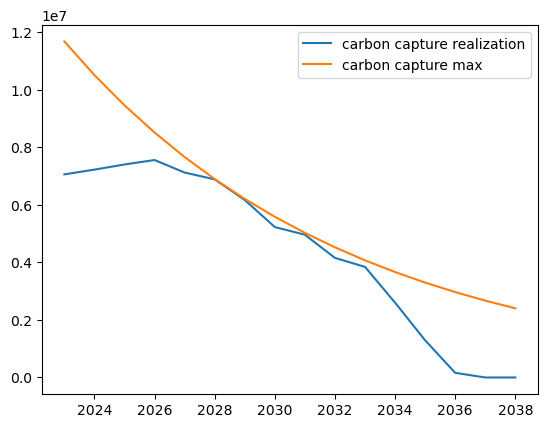

In [5]:
plt.plot(unique_year, arr_cc)
plt.plot(unique_year, arr_cc_expected)
plt.legend(['carbon capture realization', 'carbon capture max'])
plt.show()

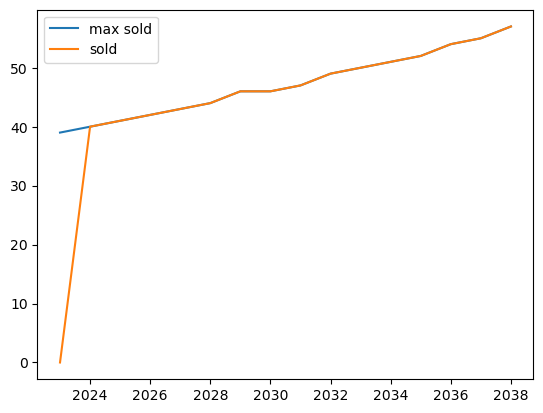

In [6]:
plt.plot(unique_year,arr_max_sold)
plt.plot(unique_year,arr_sold)
plt.legend(['max sold', 'sold'])
plt.show()

In [7]:
arr_sold, arr_max_sold

([0, 40, 41, 42, 43, 44, 46, 46, 47, 49, 50, 51, 52, 54, 55, 57],
 [39, 40, 41, 42, 43, 44, 46, 46, 47, 49, 50, 51, 52, 54, 55, 57])

In [8]:
grade_private = sum(arr_total_cost[:6])
grade_public = sum(arr_total_cost)
private_score = 100 - 70*grade_private/65000000
public_score = 100 - 70*grade_public/172000000

In [9]:
arr_total_cost

[30636049.778991092,
 510100.9993331153,
 8904921.17493247,
 10224863.218216352,
 11831502.818640966,
 10234365.05819729,
 11221854.109592767,
 11928893.7783232,
 13506658.266872637,
 13559198.521491628,
 13726084.444515482,
 11623498.359124936,
 14756760.53897094,
 14214890.568837797,
 15177059.406090077,
 8179724.690316945]

In [10]:
private_score, public_score

(22.093442871049376, 18.50843138795733)

In [11]:
arr_env_friendly

[0.1,
 0.1,
 0.1,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.5,
 0.5,
 0.30000000000000004,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1]

In [12]:
np.array(arr_cc) < np.array(arr_cc_expected)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [13]:
dict_year

{2023: [199, 159, 118, 76, 35, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 2024: [0, 3, 3, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2025: [0, 0, 44, 44, 44, 33, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2026: [0, 0, 0, 46, 46, 46, 32, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 2027: [0, 0, 0, 0, 49, 49, 49, 35, 0, 0, 0, 0, 0, 0, 0, 0],
 2028: [0, 0, 0, 0, 0, 48, 48, 48, 40, 2, 0, 0, 0, 0, 0, 0],
 2029: [0, 0, 0, 0, 0, 0, 53, 53, 53, 42, 0, 0, 0, 0, 0, 0],
 2030: [0, 0, 0, 0, 0, 0, 0, 47, 47, 47, 41, 0, 0, 0, 0, 0],
 2031: [0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 50, 40, 5, 0, 0, 0],
 2032: [0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 57, 57, 40, 13, 0, 0],
 2033: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 54, 54, 32, 8, 8],
 2034: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 56, 56, 40, 40],
 2035: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 57, 55, 55],
 2036: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 59, 58],
 2037: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 28],
 2038: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 41]}

In [14]:
dict_year_buy

{2023: [199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2024: [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2025: [0, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2026: [0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2027: [0, 0, 0, 0, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2028: [0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2029: [0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2030: [0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0],
 2031: [0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0, 0],
 2032: [0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 0, 0],
 2033: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0],
 2034: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0],
 2035: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0],
 2036: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 0, 0],
 2037: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 0],
 2038: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 65]}

In [15]:
dict_year_sell

{2023: [0, 40, 41, 42, 41, 33, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
 2024: [0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2025: [0, 0, 0, 0, 0, 11, 31, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 2026: [0, 0, 0, 0, 0, 0, 14, 30, 2, 0, 0, 0, 0, 0, 0, 0],
 2027: [0, 0, 0, 0, 0, 0, 0, 14, 35, 0, 0, 0, 0, 0, 0, 0],
 2028: [0, 0, 0, 0, 0, 0, 0, 0, 8, 38, 2, 0, 0, 0, 0, 0],
 2029: [0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 42, 0, 0, 0, 0, 0],
 2030: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 41, 0, 0, 0, 0],
 2031: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 35, 5, 0, 0],
 2032: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 27, 13, 0],
 2033: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 24, 0],
 2034: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0],
 2035: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
 2036: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 2037: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 32],
 2038: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24]}

In [16]:
#submission
arr_year = []
arr_ID = []
arr_num_vehicle = []
arr_type = []
arr_fuel = []
arr_distance_bucket = []
arr_distance_per_vehicle = []

for yr in unique_year:
    #buy
    values_ID, counts = np.unique(buy[yr]['ID'], return_counts=True)
    for i in range(len(values_ID)):
        arr_year.append(yr)
        arr_ID.append(values_ID[i])
        arr_num_vehicle.append(counts[i])
        arr_type.append('Buy')
        arr_fuel.append(None)
        arr_distance_bucket.append(None)
        arr_distance_per_vehicle.append(0)

    #use
    df_use = pd.DataFrame(use[yr])
    for i in range(len(d)):
        temp_df0 = df_use.loc[(df_use['distance_bucket'] == d[i])]
        unique_fuel = np.unique(temp_df0['fuel'])
        for j in range(len(unique_fuel)):
            temp_df1 = temp_df0.loc[(temp_df0['fuel'] == unique_fuel[j])]
            unique_dist = np.unique(temp_df1['distance'])
            for k in range(len(unique_dist)):
                temp_df2 = temp_df1.loc[(temp_df1['distance'] == unique_dist[k])]
                values_ID, counts = np.unique(temp_df2['ID'], return_counts=True)
                for l in range(len(values_ID)):
                    arr_year.append(yr)
                    arr_ID.append(values_ID[l])
                    arr_num_vehicle.append(counts[l])
                    arr_type.append('Use')
                    arr_fuel.append(unique_fuel[j])
                    arr_distance_bucket.append(d[i])
                    arr_distance_per_vehicle.append(unique_dist[k])

    #sell
    values_ID, counts = np.unique(sell[yr]['ID'], return_counts=True)
    for i in range(len(values_ID)):
        arr_year.append(yr)
        arr_ID.append(values_ID[i])
        arr_num_vehicle.append(counts[i])
        arr_type.append('Sell')
        arr_fuel.append(None)
        arr_distance_bucket.append(None)
        arr_distance_per_vehicle.append(0)

In [17]:
df_submission = pd.DataFrame({'Year': arr_year,
                              'ID': arr_ID,
                              'Num_Vehicles': arr_num_vehicle,
                              'Type': arr_type,
                              'Fuel': arr_fuel,
                              'Distance_bucket': arr_distance_bucket,
                              'Distance_per_vehicle(km)': [float(i) for i in arr_distance_per_vehicle]})
df_submission

,Year,ID,Num_Vehicles,Type,Fuel,Distance_bucket,Distance_per_vehicle(km)
0,2023,LNG_S1_2023,73,Buy,None,None,0.0
1,2023,LNG_S2_2023,34,Buy,None,None,0.0
2,2023,LNG_S3_2023,81,Buy,None,None,0.0
3,2023,LNG_S4_2023,11,Buy,None,None,0.0
4,2023,LNG_S4_2023,1,Use,LNG,D1,14576.0
...,...,...,...,...,...,...,...
812,2038,BEV_S3_2037,9,Sell,None,None,0.0
813,2038,BEV_S3_2038,16,Sell,None,None,0.0
814,2038,BEV_S4_2036,1,Sell,None,None,0.0
815,2038,BEV_S4_2037,11,Sell,None,None,0.0


In [18]:
df_submission.to_csv('submission_4.csv')

In [19]:
df_fleet = {'ID':[],
            'qty': []}

dict_cost_buy = {}
dict_cost_ins = {}
dict_cost_mnt = {}
dict_cost_fuel = {}
dict_cost_sell = {}
dict_fleet = {}
for i in unique_year:
    dict_cost_buy[i] = 0
    dict_cost_ins[i] = 0
    dict_cost_mnt[i] = 0
    dict_cost_fuel[i] = 0
    dict_cost_sell[i] = 0
    dict_fleet[i] = {}

for i in range(len(df_submission)):
    use_type = df_submission['Type'].iloc[i]
    year = df_submission['Year'].iloc[i]
    qty = df_submission['Num_Vehicles'].iloc[i]
    veh_id = df_submission['ID'].iloc[i]
    dist = df_submission['Distance_per_vehicle(km)'].iloc[i]
    fuel = df_submission['Fuel'].iloc[i]
    
    if use_type == 'Buy':
        df_fleet['ID'].append(veh_id)
        df_fleet['qty'].append(qty)

        cost_buy = vehicle_data.loc[vehicle_data['ID'] == veh_id]
        cost_buy = cost_buy['Cost ($)'].iloc[0]
        dict_cost_buy[year] = dict_cost_buy[year] + cost_buy*qty
        if i < len(df_submission)-1:
            use_type_next = df_submission['Type'].iloc[i+1]
            if (use_type_next == 'Use') & (use_type == 'Buy'):
                dict_fleet[year]['ID'] = df_fleet['ID'].copy()
                dict_fleet[year]['qty'] = df_fleet['qty'].copy()
        
    elif use_type == 'Sell':
        temp_list = np.array(df_fleet['ID'])
        idx = np.where(temp_list == veh_id)
        idx = idx[0][0]
        df_fleet['qty'][idx] = df_fleet['qty'][idx] - qty
        if df_fleet['qty'][idx] == 0:
            del df_fleet['qty'][idx]
            del df_fleet['ID'][idx]
        year_buy = veh_id.split('_')
        year_buy = int(year_buy[-1])
        delta_year = year - year_buy + 1
        temp_df = cost_profiles.loc[cost_profiles['End of Year'] == delta_year]
        pct_resale = temp_df['Resale Value %'].iloc[0]/100
        cost_buy = vehicle_data.loc[vehicle_data['ID'] == veh_id]
        cost_buy = cost_buy['Cost ($)'].iloc[0]
        cost_sell = pct_resale*cost_buy
        dict_cost_sell[year] = dict_cost_sell[year] + cost_sell*qty
    
    else:
        #cost fuel
        temp_df = vehicle_fuels.loc[vehicle_fuels['ID'] == veh_id]
        consumption_unit = temp_df.loc[(temp_df['Fuel'] == fuel)]
        consumption_unit = consumption_unit['Consumption (unit_fuel/km)'].iloc[0]
        cost_per_fuel = fuels_data.loc[(fuels_data['Fuel'] == fuel) & (fuels_data['Year'] == year)]
        cost_per_fuel = cost_per_fuel['Cost ($/unit_fuel)'].iloc[0]
        dict_cost_fuel[year] = dict_cost_fuel[year] + consumption_unit*cost_per_fuel*dist*qty
#cost mnt and ins
for i in unique_year:
    temp_df = dict_fleet[i]
    for j in range(len(temp_df['ID'])):
        veh = temp_df['ID'][j]
        qty = temp_df['qty'][j]
        year_buy = veh.split('_')
        year_buy = int(year_buy[-1])
        delta_year = i - year_buy + 1
        temp_df2 = cost_profiles.loc[cost_profiles['End of Year'] <= delta_year]
        pct_ins = temp_df2['Insurance Cost %'].iloc[-1]/100
        pct_mnt = temp_df2['Maintenance Cost %'].iloc[-1]/100

        cost_buy = vehicle_data.loc[vehicle_data['ID'] == veh]
        cost_buy = cost_buy['Cost ($)'].iloc[0]

        dict_cost_ins[i] = dict_cost_ins[i] + pct_ins*cost_buy*qty
        dict_cost_mnt[i] = dict_cost_mnt[i] + pct_mnt*cost_buy*qty
    


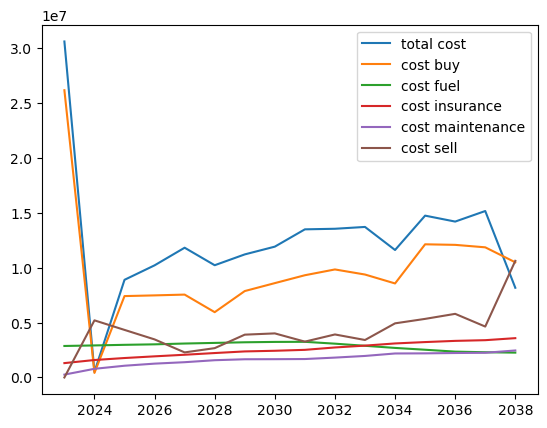

In [20]:
plt.plot(unique_year,arr_total_cost)
plt.plot(unique_year,arr_cost_buy)
plt.plot(unique_year,arr_cost_fuel)
plt.plot(unique_year,arr_cost_ins)
plt.plot(unique_year,arr_cost_mnt)
plt.plot(unique_year,arr_cost_sell)
plt.legend(['total cost', 'cost buy','cost fuel', 'cost insurance','cost maintenance','cost sell'])
plt.show()

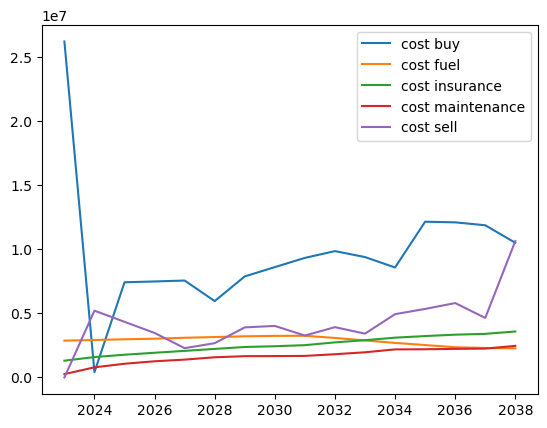

In [21]:
plt.plot(unique_year,dict_cost_buy.values())
plt.plot(unique_year,dict_cost_fuel.values())
plt.plot(unique_year,dict_cost_ins.values())
plt.plot(unique_year,dict_cost_mnt.values())
plt.plot(unique_year,dict_cost_sell.values())
plt.legend(['cost buy','cost fuel', 'cost insurance','cost maintenance','cost sell'])
plt.show()

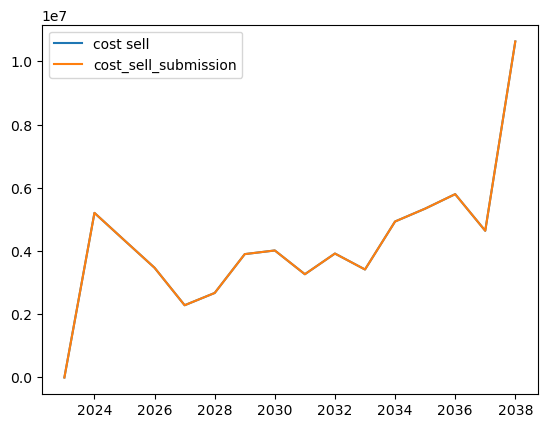

In [22]:
plt.plot(unique_year,arr_cost_sell)
plt.plot(unique_year,dict_cost_sell.values())
plt.legend(['cost sell','cost_sell_submission'])
plt.show()

In [23]:
np.array(arr_cost_sell) - np.array([i for i in dict_cost_sell.values()])

array([ 0.00000000e+00, -4.65661287e-09,  2.79396772e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.39698386e-09, -4.65661287e-10, -9.31322575e-10,  0.00000000e+00,
        0.00000000e+00,  3.72529030e-09,  0.00000000e+00, -7.45058060e-09])

In [24]:
new_arr_cost_buy= [i for i in dict_cost_buy.values()]
new_arr_cost_ins = [i for i in dict_cost_ins.values()]
new_arr_cost_mnt = [i for i in dict_cost_mnt.values()]
new_arr_cost_fuel = [i for i in dict_cost_fuel.values()]
new_arr_cost_sell = [i for i in dict_cost_sell.values()]
new_arr_total_cost = np.array(new_arr_cost_buy) + np.array(new_arr_cost_ins) + np.array(new_arr_cost_mnt) + np.array(new_arr_cost_fuel) - np.array(new_arr_cost_sell)

In [25]:
new_grade_private = sum(new_arr_total_cost[:6])
new_grade_public = sum(new_arr_total_cost)
new_private_score = 100 - 70*new_grade_private/65000000
new_public_score = 100 - 70*new_grade_public/172000000

In [26]:
new_private_score, new_public_score

(22.093442871049376, 18.508431387957344)

In [27]:
private_score, public_score

(22.093442871049376, 18.50843138795733)

In [28]:
for i in unique_year:
    values_ID, counts = np.unique(dict_total_fleet[i]['ID'], return_counts=True)
    dict_total_fleet[i]['unique_ID'] = values_ID
    dict_total_fleet[i]['qty'] = counts
    del dict_total_fleet[i]['ID']

In [29]:
for i in unique_year:
    values_ID, counts = np.unique(sell[i]['ID'], return_counts=True)
    sell[i]['unique_ID'] = values_ID
    sell[i]['qty'] = counts
    # del dict_total_fleet[i]['ID']

In [30]:
for i in unique_year:
    print(i)
    print(sell[i]['unique_ID'])
    print(sell[i]['qty'])

2023
[]
[]
2024
['LNG_S3_2023' 'LNG_S4_2023']
[29 11]
2025
['LNG_S3_2023']
[41]
2026
['LNG_S2_2023' 'LNG_S3_2023']
[31 11]
2027
['LNG_S1_2023' 'LNG_S2_2023' 'LNG_S3_2024']
[38  3  2]
2028
['LNG_S1_2023' 'LNG_S4_2025']
[33 11]
2029
['LNG_S1_2024' 'LNG_S2_2025' 'LNG_S3_2025' 'LNG_S3_2026']
[ 1  1 30 14]
2030
['LNG_S1_2025' 'LNG_S3_2026' 'LNG_S3_2027' 'LNG_S4_2027']
[ 2 30 13  1]
2031
['LNG_S1_2023' 'LNG_S1_2026' 'LNG_S1_2027' 'LNG_S1_2028' 'LNG_S2_2027']
[ 2  2  3  8 32]
2032
['LNG_S1_2028' 'LNG_S2_2028' 'LNG_S3_2028' 'LNG_S4_2029']
[30  4  4 11]
2033
['LNG_S1_2028' 'LNG_S1_2029' 'LNG_S2_2029' 'LNG_S2_2030' 'LNG_S3_2029'
 'LNG_S3_2030']
[ 2 36  2  1  4  5]
2034
['BEV_S1_2030' 'LNG_S3_2030' 'LNG_S3_2031' 'LNG_S4_2031']
[ 2 39  9  1]
2035
['BEV_S2_2032' 'LNG_S3_2031' 'LNG_S3_2032' 'LNG_S4_2032']
[12 35  4  1]
2036
['BEV_S1_2031' 'BEV_S1_2032' 'BEV_S2_2032' 'BEV_S2_2033' 'BEV_S4_2033'
 'LNG_S3_2033']
[ 5  5 22  5 11  6]
2037
['BEV_S1_2032' 'BEV_S1_2033' 'BEV_S2_2034' 'BEV_S3_2034' 'BEV_S4_2

In [31]:
dict_cost_sell

{2023: 0,
 2024: 5208750.4,
 2025: 4337603.2,
 2026: 3471297.5999999996,
 2027: 2286304.0,
 2028: 2674551.0,
 2029: 3904109.5,
 2030: 4019581.4,
 2031: 3267764.2,
 2032: 3922247.4,
 2033: 3417545.4,
 2034: 4936104.2,
 2035: 5342804.500000001,
 2036: 5801613.1,
 2037: 4642918.199999999,
 2038: 10633586.5}

In [32]:
arr_cost_sell

[0,
 5208750.399999996,
 4337603.200000003,
 3471297.5999999996,
 2286304.0,
 2674551.0,
 3904109.5,
 4019581.4,
 3267764.2000000016,
 3922247.3999999994,
 3417545.399999999,
 4936104.2,
 5342804.500000001,
 5801613.100000003,
 4642918.199999999,
 10633586.499999993]